## downsample neural data to 500hz, windowed at 25hz, save as npy, and extract features and save as npy WIP

In [1]:
import os
import mne
import numpy as np
from scipy.signal import find_peaks, hilbert, welch
from scipy.fft import fft, fftfreq
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# Path to your EDF file
file_path = '/home/vincent/datasets/bio-silicon/sub-01_ses-task_task-game_run-01_ieeg.edf'

# Load the EDF file
raw = mne.io.read_raw_edf(file_path, preload=True, stim_channel=None)

# Electrode names matched to centroids (retrieved from your earlier analysis)
matched_names = ['B21', 'A48', 'B56', 'A5', 'B57', 'B55', 'B4', 'B17', 'B18', 'A46', 'A9', 'A16', 'A18', 'A12', 'A39', 'A43', 'A13', 'B51', 'A38', 'B25', 'B37', 'B36', 'B44', 'B54', 'A34', 'A3', 'A24', 'A31', 'B48', 'B33', 'B40', 'B22']

# Function to generate the corresponding channel names with the "POL" prefix
def generate_pol_channel_name(name):
    if name.startswith('POL'):
        return name
    elif name.startswith('EEG'):
        return f'POL {name[4:]}'
    else:
        return f'POL {name}'  # Assuming other prefixes can be safely prefixed with "POL"

# Adjusted matched names with "POL" prefix
adjusted_matched_names = [generate_pol_channel_name(name) for name in matched_names]

print("Adjusted matched names:", adjusted_matched_names)

# Filter to keep only the indices of channels that are in adjusted_matched_names
indices = [raw.ch_names.index(name) for name in adjusted_matched_names if name in raw.ch_names]

print("Number of channels selected:", len(indices))  # Print the number of selected channels

# Extract data for these channels
selected_data, times = raw[indices, :]

# Downsample the data to 500 Hz if the original sampling rate is 1000 Hz
if raw.info['sfreq'] == 1000:
    raw.resample(500)

# Extract the downsampled data
selected_data, times = raw[indices, :]

# Function to segment the data
def segment_data(data, segment_length):
    num_segments = data.shape[1] // segment_length
    segmented_data = np.array(np.split(data[:, :num_segments * segment_length], num_segments, axis=1))
    return segmented_data

# Segment length for 0.25 seconds at 500 Hz
segment_length = 125

# Segment the data
segmented_data = segment_data(selected_data, segment_length)

print(f"Segmented data shape: {segmented_data.shape}")  # Should be (num_segments, 32, 125)

# Normalize the data to the range [0, 1]
def normalize_data(data):
    data_min = np.min(data, axis=(0, 2), keepdims=True)
    data_max = np.max(data, axis=(0, 2), keepdims=True)
    normalized_data = (data - data_min) / (data_max - data_min)
    return normalized_data

normalized_data = normalize_data(segmented_data)

# Peak detection function
def detect_peaks(signal):
    median_height = np.median(signal)
    std_height = np.std(signal)
    height = median_height + std_height  # Setting height to be above median + 1 std deviation
    distance = len(signal) * 0.05  # Example to set distance to 5% of signal length
    prominence = std_height * 0.5  # Setting prominence to be half of std deviation
    
    # Detecting peaks
    peaks, properties = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    
    peak_count = len(peaks)
    average_peak_height = np.mean(properties["peak_heights"]) if "peak_heights" in properties else 0
    average_distance = np.mean(np.diff(peaks)) if len(peaks) > 1 else 0
    average_prominence = np.mean(properties["prominences"]) if "prominences" in properties else 0

    return {
        "peak_counts": peak_count,
        "average_peak_height": average_peak_height,
        "average_distance": average_distance,
        "average_prominence": average_prominence,
    }

# Calculate variance and standard deviation
def calculate_variance_std_dev(signal):
    variance = np.var(signal)
    std_dev = np.std(signal)
    return variance, std_dev

# Calculate RMS
def calculate_rms(signal):
    rms = np.sqrt(np.mean(signal**2))
    return rms

# Frequency bands and PSD
def freq_bands(signal, fs=500):
    band_features = {}
    frequencies, psd = welch(signal, fs=fs, nperseg=min(32, len(signal)))
    bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
    for name, (low, high) in bands.items():
        idx = np.logical_and(frequencies >= low, frequencies <= high)
        band_features[f'{name}_band_power'] = np.mean(psd[idx])
    return band_features, frequencies, psd

# Calculate spectral entropy
def calculate_spectral_entropy(signal, fs=500):
    frequencies, psd = welch(signal, fs=fs, nperseg=min(len(signal), fs * 2))
    normalized_psd = psd / np.sum(psd)
    spectral_entropy = -np.sum(normalized_psd * np.log2(normalized_psd))
    return spectral_entropy

# Spectral centroids
def spectral_centroids(signal, fs=500):
    fft_result = fft(signal)
    frequencies = fftfreq(len(signal), 1.0/fs)
    magnitude = np.abs(fft_result)
    centroid = np.sum(frequencies * magnitude) / np.sum(magnitude)
    return centroid

# Spectral edge density
def spectral_edge_density(signal, fs=500, percentage=95):
    fft_result = fft(signal)
    frequencies = fftfreq(len(signal), 1.0/fs)
    positive_frequencies = frequencies[frequencies >= 0]
    positive_fft_result = np.abs(fft_result[frequencies >= 0])
    cumulative_sum = np.cumsum(np.sort(positive_fft_result)[::-1])
    total_power = np.sum(positive_fft_result)
    threshold = total_power * (percentage / 100)
    spectral_edge = positive_frequencies[np.argmax(cumulative_sum >= threshold)]
    return spectral_edge

# Phase locking values
def phase_locking_values(signals):
    num_signals = signals.shape[0]
    plv_matrix = np.zeros((num_signals, num_signals))
    for i in range(num_signals):
        for j in range(i+1, num_signals):  # Only compute for unique pairs
            signal1 = signals[i]
            signal2 = signals[j]
            analytic_signal1 = hilbert(signal1)
            analytic_signal2 = hilbert(signal2)
            phase1 = np.angle(analytic_signal1)
            phase2 = np.angle(analytic_signal2)
            phase_diff = phase1 - phase2
            plv = np.abs(np.sum(np.exp(1j * phase_diff)) / len(signal1))
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric
    return plv_matrix

# Higuchi Fractal Dimension
def calculate_higuchi_fractal_dimension(signal, k_max=10):
    hfd_values = []
    N = len(signal)
    L = []
    x = np.asarray(signal)
    for k in range(1, k_max + 1):
        Lk = []
        for m in range(k):
            Lkm_sum = 0
            max_index = int((N - m - 1) / k) + 1  # Ensures valid indexing
            for i in range(1, max_index):
                Lkm_sum += abs(x[m + i*k] - x[m + (i-1)*k])
            if max_index - 1 > 0:  # Check to avoid division by zero
                Lkm = Lkm_sum * (N - 1) / (k * (max_index - 1))
                Lk.append(Lkm)
            else:
                Lk.append(0)  # Or handle appropriately
        if np.mean(Lk) > 0:
            L.append(np.log(np.mean(Lk)))
        else:
            L.append(np.log(np.finfo(float).eps))  # Using machine epsilon for a small positive number
    if len(L) > 0 and np.all(np.isfinite(L)):
        hfd = np.polyfit(np.log(range(1, k_max + 1)), L, 1)[0]  # Linear fit to log-log plot
        hfd_values.append(hfd)
    else:
        hfd_values.append(np.nan)  # Append NaN or another placeholder to indicate failure
    return hfd_values

# Zero Crossing Rate
def calculate_zero_crossing_rate(signal):
    sign_changes = np.diff(np.sign(signal))
    zero_crossings = np.count_nonzero(sign_changes)
    zero_crossing_rate = zero_crossings / (len(signal) - 1)
    return zero_crossing_rate

# Time Warping Factor
def time_warping_factor(signals):
    average_signal = np.mean(signals, axis=0)
    warping_factors = []
    for signal in signals:
        signal = np.squeeze(signal)
        average_signal = np.squeeze(average_signal)
        distance, _ = fastdtw(signal, average_signal, dist=euclidean)
        warping_factors.append(distance)
    return warping_factors

# Evolution Rate
def evolution_rate(signal):
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    derivative = np.diff(envelope)
    rate = np.mean(np.abs(derivative))
    return rate

# Extract features function
def extract_features(signals, fs=500):
    features_list = []
    
    for signal in signals:
        features = {}
        
        peaks_results = detect_peaks(signal)
        variance, std_dev = calculate_variance_std_dev(signal)
        rms = calculate_rms(signal)
        band_features, frequencies, psd = freq_bands(signal, fs)
        spectral_entropy = calculate_spectral_entropy(signal, fs)
        centroid = spectral_centroids(signal, fs)
        spectral_edge = spectral_edge_density(signal, fs)
        plv = phase_locking_values(np.expand_dims(signal, axis=0))  # Make sure PLV gets the right shape
        hfd_values = calculate_higuchi_fractal_dimension(signal)
        zero_crossing_rate = calculate_zero_crossing_rate(signal)
        rate = evolution_rate(signal)
        
        features.update({
            "peak_height": peaks_results.get('peak_heights', []),
            "peak_counts": peaks_results['peak_counts'],
            "average_peak_height": peaks_results['average_peak_height'],
            "average_distance": peaks_results['average_distance'],
            "average_prominence": peaks_results['average_prominence'],
            "variance": variance,
            "std_dev": std_dev,
            "rms": rms,
            "delta_band_power": band_features['delta_band_power'],
            "theta_band_power": band_features['theta_band_power'],
            "alpha_band_power": band_features['alpha_band_power'],
            "beta_band_power": band_features['beta_band_power'],
            "spectral_entropy": spectral_entropy,
            "fft_results": fft(signal),
            "magnitudes": np.abs(fft(signal)),
            "centroids": centroid,
            "spectral_edge_density": spectral_edge,
            "phases": np.angle(hilbert(signal)),
            "pairwise_phase_locking_values": plv,
            "higuchi_fractal_dimension": hfd_values[0],
            "zero_crossing_rate": zero_crossing_rate,
            "IMFS": [],  # Placeholder for IMFs
            "signal_shapes": signal.shape,
            "average_signal_shapes": np.mean(signal),
            "evolution_rate": rate,
            "analytic_signals": hilbert(signal),
            "envelopes": np.abs(hilbert(signal)),
            "derivatives": np.diff(np.abs(hilbert(signal))),
        })
        
        features_list.append(features)
    
    return features_list, frequencies, psd

# Extract features from each window
features_list = []
for window in normalized_data:
    features, frequencies, psd = extract_features(window)
    features_list.append(features)

# Ensure the directory exists
save_dir = '/home/vincent/datasets/bio-silicon'
os.makedirs(save_dir, exist_ok=True)

# Save the normalized data and features
np.save(os.path.join(save_dir, 'normalized_neural_data.npy'), normalized_data)
np.save(os.path.join(save_dir, 'extracted_features.npy'), features_list)

print("Feature extraction complete. Data saved at /home/vincent/datasets/bio-silicon.")


Extracting EDF parameters from /home/vincent/datasets/bio-silicon/sub-01_ses-task_task-game_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1898115  =      0.000 ...  1898.115 secs...
Adjusted matched names: ['POL B21', 'POL A48', 'POL B56', 'POL A5', 'POL B57', 'POL B55', 'POL B4', 'POL B17', 'POL B18', 'POL A46', 'POL A9', 'POL A16', 'POL A18', 'POL A12', 'POL A39', 'POL A43', 'POL A13', 'POL B51', 'POL A38', 'POL B25', 'POL B37', 'POL B36', 'POL B44', 'POL B54', 'POL A34', 'POL A3', 'POL A24', 'POL A31', 'POL B48', 'POL B33', 'POL B40', 'POL B22']
Number of channels selected: 32
Segmented data shape: (7592, 32, 125)


/home/vincent/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vincent/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Feature extraction complete. Data saved at /home/vincent/datasets.


## print features contents

In [2]:
import numpy as np

# Load the extracted features
features_path = '/home/vincent/datasets/bio-silicon/extracted_features.npy'
features_list = np.load(features_path, allow_pickle=True)

# Calculate the number of segments per second (since each segment is 0.25 seconds)
segments_per_second = 4

# Get the number of segments for the first 5 seconds
num_segments = segments_per_second * 5

def print_feature(name, value):
    if isinstance(value, (list, np.ndarray)):
        print(f"{name}: {np.array(value).shape}")
        if len(value) <= 10:  # Print small arrays entirely
            print(value)
        else:
            print(f"{value[:10]}...")  # Print only the first 10 elements of large arrays
    elif isinstance(value, dict):
        print(f"{name}: dict with keys {list(value.keys())}")
    else:
        print(f"{name}: {value}")

# Print all features for the first 5 seconds of data
for i in range(num_segments):
    print(f"Features for segment {i + 1} (time window {i * 0.25} to {(i + 1) * 0.25} seconds):")
    features_array = features_list[i]
    if isinstance(features_array, np.ndarray):
        for features in features_array:
            if isinstance(features, dict):  # Ensure it's a dictionary
                for key, value in features.items():
                    print_feature(key, value)
            else:
                print(f"The feature is not in the expected dictionary format. Found type: {type(features)}")
    else:
        print(f"The feature is not in the expected dictionary format. Found type: {type(features_array)}")
    print("\n" + "-"*50 + "\n")

Features for segment 1 (time window 0.0 to 0.25 seconds):
peak_height: (0,)
[]
peak_counts: 5
average_peak_height: 0.5079212106393244
average_distance: 14.75
average_prominence: 0.06723033045428184
variance: 0.0011257027138713545
std_dev: 0.033551493467077656
rms: 0.44976274712502184
delta_band_power: nan
theta_band_power: nan
alpha_band_power: nan
beta_band_power: 2.4896638203875245e-05
spectral_entropy: 3.4499169388732605
fft_results: (125,)
[56.06369508-0.j         -0.18520568+1.50435089j -0.45846848+0.46659581j
 -0.82139928-0.6311641j   0.666536  +0.89753252j -0.35861259+1.22257631j
  0.38786818+0.02222775j -0.12796837-0.19214113j  0.10029156-0.09601887j
 -0.26412714+0.26402626j]...
magnitudes: (125,)
[56.06369508  1.51570866  0.65414447  1.03588846  1.11796014  1.27408627
  0.38850456  0.23085519  0.13884531  0.37346086]...
centroids: -5.623450663373117e-16
spectral_edge_density: 80.0
phases: (125,)
[ 0.1897029   0.07623807  0.05516299  0.07301684  0.12778462  0.03884481
  0.05536

## create tensors for each feature WIP

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import os

# Load the extracted features
features_path = '/home/vincent/datasets/bio-silicon/extracted_features.npy'
features_list = np.load(features_path, allow_pickle=True)

# Preprocess the features to create a tensor for each feature
def preprocess_features(features_list):
    all_features = {key: [] for key in features_list[0][0].keys()}
    
    for segment in features_list:
        segment_features = {key: [] for key in all_features.keys()}
        for channel in segment:
            if isinstance(channel, dict):
                for key, value in channel.items():
                    if isinstance(value, np.ndarray):
                        segment_features[key].append(value)
                    else:
                        segment_features[key].append(np.array([value]))
        for key in segment_features.keys():
            all_features[key].append(np.stack(segment_features[key], axis=0))
    
    # Convert lists to numpy arrays for each feature
    for key in all_features.keys():
        all_features[key] = np.array(all_features[key])
    
    return all_features

# Convert the features to a tensor dictionary
features_dict = preprocess_features(features_list)
tensor_dict = {key: torch.tensor(features_dict[key], dtype=torch.float32) for key in features_dict.keys()}

# Assume we have corresponding labels (for illustration)
# Each label corresponds to one 0.25-second window
labels_array = np.random.randint(0, 2, size=(tensor_dict['peak_counts'].shape[0],))
labels_tensor = torch.tensor(labels_array, dtype=torch.float32)

# Save the tensors
save_dir = '/home/vincent/datasets/bio-silicon/tensors'
os.makedirs(save_dir, exist_ok=True)

for key, tensor in tensor_dict.items():
    torch.save(tensor, os.path.join(save_dir, f'{key}_tensor.pt'))

torch.save(labels_tensor, os.path.join(save_dir, 'labels_tensor.pt'))

print(f"All tensors have been saved in {save_dir}.")

# Create a TensorDataset and DataLoader for each feature
datasets = {}
for key, tensor in tensor_dict.items():
    datasets[key] = TensorDataset(tensor, labels_tensor)

# Split each dataset into train, validation, and test sets
train_datasets = {}
val_datasets = {}
test_datasets = {}

for key, dataset in datasets.items():
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_datasets[key], val_datasets[key], test_datasets[key] = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each feature
train_loaders = {key: DataLoader(ds, batch_size=32, shuffle=True) for key, ds in train_datasets.items()}
val_loaders = {key: DataLoader(ds, batch_size=32) for key, ds in val_datasets.items()}
test_loaders = {key: DataLoader(ds, batch_size=32) for key, ds in test_datasets.items()}

# Now you can use train_loaders, val_loaders, and test_loaders in your training loop
# For example, to access the DataLoader for 'peak_counts':
train_loader_peak_counts = train_loaders['peak_counts']
val_loader_peak_counts = val_loaders['peak_counts']
test_loader_peak_counts = test_loaders['peak_counts']

# Example of iterating through the DataLoader for 'peak_counts'
for inputs, labels in train_loader_peak_counts:
    # Your training loop here
    print("Inputs:", inputs)
    print("Labels:", labels)
    break  # Just to illustrate the first batch

/tmp/ipykernel_59752/442225448.py:34: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  tensor_dict = {key: torch.tensor(features_dict[key], dtype=torch.float32) for key in features_dict.keys()}


All tensors have been saved in /home/vincent/datasets/bio-silicon/tensors.
Inputs: tensor([[[ 2.],
         [ 6.],
         [ 1.],
         ...,
         [ 2.],
         [ 1.],
         [ 2.]],

        [[ 3.],
         [ 9.],
         [ 2.],
         ...,
         [ 4.],
         [ 1.],
         [ 2.]],

        [[ 1.],
         [ 3.],
         [ 1.],
         ...,
         [ 2.],
         [ 2.],
         [ 2.]],

        ...,

        [[ 5.],
         [ 6.],
         [ 1.],
         ...,
         [ 1.],
         [ 1.],
         [ 2.]],

        [[ 3.],
         [ 6.],
         [ 1.],
         ...,
         [ 3.],
         [ 3.],
         [ 4.]],

        [[ 3.],
         [10.],
         [ 2.],
         ...,
         [ 3.],
         [ 0.],
         [ 4.]]])
Labels: tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.])


In [6]:
import numpy as np
import torch
import os

# List all tensors and their shapes
for key, tensor in tensor_dict.items():
    print(f'Tensor name: {key}, Tensor shape: {tensor.shape}')

# Also print the labels tensor
print(f'Tensor name: labels_tensor, Tensor shape: {labels_tensor.shape}')

Tensor name: peak_height, Tensor shape: torch.Size([7592, 32, 1, 0])
Tensor name: peak_counts, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: average_peak_height, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: average_distance, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: average_prominence, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: variance, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: std_dev, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: rms, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: delta_band_power, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: theta_band_power, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: alpha_band_power, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: beta_band_power, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: spectral_entropy, Tensor shape: torch.Size([7592, 32, 1])
Tensor name: fft_results, Tensor shape: torch.Size([7592, 32, 125])
Tensor name: magnitudes, Tensor shape: tor

## custom activation functions WIP

In [1]:
import numpy as np
import torch
import torch.nn as nn

class PeakHeightActivation(nn.Module):
    def __init__(self, filepath):
        super(PeakHeightActivation, self).__init__()
        self.peak_height_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        peak_height = torch.tensor(self.peak_height_values, device=x.device)
        return x * peak_height  # Scale by peak height

class PeakCountsActivation(nn.Module):
    def __init__(self, filepath):
        super(PeakCountsActivation, self).__init__()
        self.peak_counts_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        peak_counts = torch.tensor(self.peak_counts_values, device=x.device)
        return x * peak_counts  # Scale by peak counts

class AveragePeakHeightActivation(nn.Module):
    def __init__(self, filepath):
        super(AveragePeakHeightActivation, self).__init__()
        self.average_peak_height_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        average_peak_height = torch.tensor(self.average_peak_height_values, device=x.device)
        return x * average_peak_height  # Scale by average peak height

class AverageDistanceActivation(nn.Module):
    def __init__(self, filepath):
        super(AverageDistanceActivation, self).__init__()
        self.average_distance_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        average_distance = torch.tensor(self.average_distance_values, device=x.device)
        return x * average_distance  # Scale by average distance

class AverageProminenceActivation(nn.Module):
    def __init__(self, filepath):
        super(AverageProminenceActivation, self).__init__()
        self.prominence_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        prominence = torch.tensor(self.prominence_values, device=x.device)
        return x * prominence  # Scale by prominence

class VarianceActivation(nn.Module):
    def __init__(self, filepath):
        super(VarianceActivation, self).__init__()
        self.variance_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        variance = torch.tensor(self.variance_values, device=x.device)
        return x * variance  # Scale by variance

class StdDevActivation(nn.Module):
    def __init__(self, filepath):
        super(StdDevActivation, self).__init__()
        self.std_dev_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        std_dev = torch.tensor(self.std_dev_values, device=x.device)
        return x * std_dev  # Scale by standard deviation

class RMSActivation(nn.Module):
    def __init__(self, filepath):
        super(RMSActivation, self).__init__()
        self.rms_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        rms = torch.tensor(self.rms_values, device=x.device)
        return x * rms  # Scale by RMS

class FrequenciesActivation(nn.Module):
    def __init__(self, filepath):
        super(FrequenciesActivation, self).__init__()
        self.frequencies_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        frequencies = torch.tensor(self.frequencies_values, device=x.device)
        return x * frequencies  # Scale by frequencies

class PSDActivation(nn.Module):
    def __init__(self, filepath):
        super(PSDActivation, self).__init__()
        self.psd_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        psd = torch.tensor(self.psd_values, device=x.device)
        return x * psd  # Scale by PSD

class SpectralEntropyActivation(nn.Module):
    def __init__(self, filepath):
        super(SpectralEntropyActivation, self).__init__()
        self.spectral_entropy_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        spectral_entropy = torch.tensor(self.spectral_entropy_values, device=x.device)
        return x * spectral_entropy  # Scale by spectral entropy

class FFTResultsActivation(nn.Module):
    def __init__(self, filepath):
        super(FFTResultsActivation, self).__init__()
        self.fft_results_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        fft_results = torch.tensor(self.fft_results_values, device=x.device)
        return x * fft_results  # Scale by FFT results

class MagnitudesActivation(nn.Module):
    def __init__(self, filepath):
        super(MagnitudesActivation, self).__init__()
        self.magnitudes_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        magnitudes = torch.tensor(self.magnitudes_values, device=x.device)
        return x * magnitudes  # Scale by magnitudes

class CentroidsActivation(nn.Module):
    def __init__(self, filepath):
        super(CentroidsActivation, self).__init__()
        self.centroids_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        centroids = torch.tensor(self.centroids_values, device=x.device)
        return x * centroids  # Scale by centroids

class SpectralEdgeDensityActivation(nn.Module):
    def __init__(self, filepath):
        super(SpectralEdgeDensityActivation, self).__init__()
        self.spectral_edge_density_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        spectral_edge_density = torch.tensor(self.spectral_edge_density_values, device=x.device)
        return x * spectral_edge_density  # Scale by spectral edge density

class PositiveFrequenciesActivation(nn.Module):
    def __init__(self, filepath):
        super(PositiveFrequenciesActivation, self).__init__()
        self.positive_frequencies_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        positive_frequencies = torch.tensor(self.positive_frequencies_values, device=x.device)
        return x * positive_frequencies  # Scale by positive frequencies

class PositiveFFTResultsActivation(nn.Module):
    def __init__(self, filepath):
        super(PositiveFFTResultsActivation, self).__init__()
        self.positive_fft_results_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        positive_fft_results = torch.tensor(self.positive_fft_results_values, device=x.device)
        return x * positive_fft_results  # Scale by positive FFT results

class CumulativeSumsActivation(nn.Module):
    def __init__(self, filepath):
        super(CumulativeSumsActivation, self).__init__()
        self.cumulative_sums_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        cumulative_sums = torch.tensor(self.cumulative_sums_values, device=x.device)
        return x * cumulative_sums  # Scale by cumulative sums

class TotalPowersActivation(nn.Module):
    def __init__(self, filepath):
        super(TotalPowersActivation, self).__init__()
        self.total_powers_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        total_powers = torch.tensor(self.total_powers_values, device=x.device)
        return x * total_powers  # Scale by total powers

class ThresholdsActivation(nn.Module):
    def __init__(self, filepath):
        super(ThresholdsActivation, self).__init__()
        self.thresholds_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        threshold = torch.tensor(self.thresholds_values, device=x.device)
        return x * threshold  # Scale by thresholds

class PhasesActivation(nn.Module):
    def __init__(self, filepath):
        super(PhasesActivation, self).__init__()
        self.phases_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        phases = torch.tensor(self.phases_values, device=x.device)
        return x * phases  # Scale by phases

class PairwisePhaseLockingValuesActivation(nn.Module):
    def __init__(self, filepath):
        super(PairwisePhaseLockingValuesActivation, self).__init__()
        self.pairwise_phase_locking_values_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        pairwise_phase_locking_values = torch.tensor(self.pairwise_phase_locking_values_values, device=x.device)
        return x * pairwise_phase_locking_values  # Scale by pairwise phase locking values

class HiguchiFractalDimensionActivation(nn.Module):
    def __init__(self, filepath):
        super(HiguchiFractalDimensionActivation, self).__init__()
        self.hfd_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        hfd_values = torch.tensor(self.hfd_values, device=x.device)
        return x * hfd_values  # Scale by Higuchi fractal dimension values
       
class PhaseSpaceActivation(nn.Module):
    def __init__(self, filepath):
        super(PhaseSpaceActivation, self).__init__()
        self.phase_space_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        phase_space = torch.tensor(self.phase_space_values, device=x.device)
        return phase_space

class UMAPActivation(nn.Module):
    def __init__(self, filepath):
        super(UMAPActivation, self).__init__()
        self.umap_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        umap = torch.tensor(self.umap_values, device=x.device)
        return umap

class TSNEActivation(nn.Module):
    def __init__(self, filepath):
        super(TSNEActivation, self).__init__()
        self.tsne_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        tsne = torch.tensor(self.tsne_values, device=x.device)
        return tsne

class SampleEntropyActivation(nn.Module):
    def __init__(self, filepath):
        super(SampleEntropyActivation, self).__init__()
        self.sample_entropy_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        sample_entropy = torch.tensor(self.sample_entropy_values, device=x.device)
        return sample_entropy

class BoxCountingDimensionActivation(nn.Module):
    def __init__(self, filepath):
        super(BoxCountingDimensionActivation, self).__init__()
        self.box_counting_dimension_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        box_counting_dimension = torch.tensor(self.box_counting_dimension_values, device=x.device)
        return box_counting_dimension

class TopologicalActivation(nn.Module):
    def __init__(self, filepath):
        super(TopologicalActivation, self).__init__()
        self.topological_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        topological = torch.tensor(self.topological_values, device=x.device)
        return topological

class LyapunovActivation(nn.Module):
    def __init__(self, filepath):
        super(LyapunovActivation, self).__init__()
        self.lyapunov_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        lyapunov = torch.tensor(self.lyapunov_values, device=x.device)
        return lyapunov

class KatzFractalDimensionActivation(nn.Module):
    def __init__(self, filepath):
        super(KatzFractalDimensionActivation, self).__init__()
        self.katz_fractal_dimension_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        katz_fractal_dimension = torch.tensor(self.katz_fractal_dimension_values, device=x.device)
        return katz_fractal_dimension

class MultiscaleEntropyActivation(nn.Module):
    def __init__(self, filepath):
        super(MultiscaleEntropyActivation, self).__init__()
        self.multiscale_entropy_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        multiscale_entropy = torch.tensor(self.multiscale_entropy_values, device=x.device)
        return multiscale_entropy

class WaveletFractalActivation(nn.Module):
    def __init__(self, filepath):
        super(WaveletFractalActivation, self).__init__()
        self.wavelet_fractal_values = np.memmap(filepath, dtype='float32', mode='r')

    def forward(self, x):
        wavelet_fractal = torch.tensor(self.wavelet_fractal_values, device=x.device)
        return wavelet_fractal




need to fix the rest of these for memmap npy
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
class ApproximateEntropyActivation(nn.Module):
    def __init__(self, m=2, r=0.2):
        super(ApproximateEntropyActivation, self).__init__()
        self.m = m
        self.r = r

    def forward(self, x):
        N = x.size(1)
        phi_m = torch.mean(torch.abs(x[:, None, :N - self.m] - x[:, None, self.m:N]))
        phi_m_plus_one = torch.mean(torch.abs(x[:, None, :N - self.m - 1] - x[:, None, self.m + 1:N]))
        return torch.log(phi_m / (phi_m_plus_one + 1e-9))

class NetworkFractalDimensionActivation(nn.Module):
    def __init__(self):
        super(NetworkFractalDimensionActivation, self).__init__()

    def forward(self, x):
        adjacency_matrix = (x @ x.T) > 0.5
        return torch.log(torch.sum(adjacency_matrix.float())) / torch.log(torch.tensor(adjacency_matrix.size(-1)).float())

class HamiltonianActivation(nn.Module):
    def __init__(self):
        super(HamiltonianActivation, self).__init__()

    def forward(self, x):
        H = x.T @ x - x @ x.T
        return H

class SpectrumAnalysisActivation(nn.Module):
    def __init__(self):
        super(SpectrumAnalysisActivation, self).__init__()

    def forward(self, x):
        spectrum = torch.fft.fft2(x)
        response_surface = torch.abs(spectrum)
        return response_surface

class HarmonicsDetectionActivation(nn.Module):
    def __init__(self):
        super(HarmonicsDetectionActivation, self).__init__()

    def forward(self, x):
        harmonics = torch.fft.fft(x)
        return harmonics.abs()

class HarmonicsLyapunovActivation(nn.Module):
    def __init__(self):
        super(HarmonicsLyapunovActivation, self).__init__()

    def forward(self, x):
        harmonics = torch.fft.fft(x)
        lyapunov_exponent = torch.log(torch.abs(harmonics) + 1e-9)
        return lyapunov_exponent

class ResonanceFrequencyActivation(nn.Module):
    def __init__(self):
        super(ResonanceFrequencyActivation, self).__init__()

    def forward(self, x):
        stft = torch.stft(x, n_fft=128, hop_length=64)
        return torch.abs(stft)

class WeightedUndirectedNetworkActivation(nn.Module):
    def __init__(self):
        super(WeightedUndirectedNetworkActivation, self).__init__()

    def forward(self, x):
        adjacency_matrix = x @ x.T
        return adjacency_matrix

class PhaseSpaceCentroidsActivation(nn.Module):
    def __init__(self):
        super(PhaseSpaceCentroidsActivation, self).__init__()

    def forward(self, x):
        phase_space_2d = torch.stack((x[:, :-1], x[:, 1:]), dim=-1)
        centroids = torch.mean(phase_space_2d, dim=1)
        return centroids

class MultipartiteConcurrenceActivation(nn.Module):
    def __init__(self):
        super(MultipartiteConcurrenceActivation, self).__init__()

    def forward(self, x):
        concurrence = torch.abs(x @ x.T.conj())
        return concurrence

class LaplaceTransformActivation(nn.Module):
    def __init__(self):
        super(LaplaceTransformActivation, self).__init__()

    def forward(self, x):
        s = torch.fft.fft(x)
        return torch.fft.ifft(s / (s + 1e-9))

class SymplecticActivation(nn.Module):
    def __init__(self):
        super(SymplecticActivation, self).__init__()

    def forward(self, x):
        return x @ torch.eye(x.size(1)).to(x.device)

class HyperbolicActivation(nn.Module):
    def __init__(self):
        super(HyperbolicActivation, self).__init__()

    def forward(self, x):
        return torch.sinh(x)

class GeodesicGaussianCurvatureActivation(nn.Module):
    def __init__(self):
        super(GeodesicGaussianCurvatureActivation, self).__init__()

    def forward(self, x):
        curvature = 1 / (1 + torch.sum(x**2, dim=-1))
        return curvature.unsqueeze(-1)

class TheoremaEgregiumActivation(nn.Module):
    def __init__(self):
        super(TheoremaEgregiumActivation, self).__init__()

    def forward(self, x):
        return x / torch.sqrt(1 + torch.sum(x**2, dim=-1)).unsqueeze(-1)

class RiemannianActivation(nn.Module):
    def __init__(self):
        super(RiemannianActivation, self).__init__()

    def forward(self, x):
        return torch.exp(-torch.norm(x, dim=-1)).unsqueeze(-1)

class RiemannCurvatureActivation(nn.Module):
    def __init__(self):
        super(RiemannCurvatureActivation, self).__init__()

    def forward(self, x):
        # Compute the gradient of the input tensor
        gradient = torch.autograd.grad(x.sum(), x, create_graph=True)[0]

        # Compute the Laplacian of the input tensor
        laplacian = sum(torch.autograd.grad(gradient[:, i].sum(), x, create_graph=True)[0][:, i] for i in range(x.shape[1]))

        # Compute the Riemannian Curvature-like quantity
        riemann_curvature = torch.norm(laplacian)

        # Apply a scaling factor to control the magnitude of the curvature
        scaled_curvature = torch.tanh(riemann_curvature)  # You can experiment with different scaling functions

        return scaled_curvature

class JacobianActivation(nn.Module):
    def __init__(self):
        super(JacobianActivation, self).__init__()

    def forward(self, x):
        J = torch.autograd.functional.jacobian(lambda x: x, x)
        return J

class LyapunovVectorsActivation(nn.Module):
    def __init__(self):
        super(LyapunovVectorsActivation, self).__init__()

    def forward(self, x):
        return torch.log(torch.abs(x) + 1e-9)

class LyapunovStabilityActivation(nn.Module):
    def __init__(self):
        super(LyapunovStabilityActivation, self).__init__()

    def forward(self, x):
        return torch.exp(-torch.abs(x))

class LyapunovDimensionActivation(nn.Module):
    def __init__(self):
        super(LyapunovDimensionActivation, self).__init__()

    def forward(self, x):
        return torch.sum(torch.log(1 + torch.abs(x)), dim=-1).unsqueeze(-1)

class OGYActivation(nn.Module):
    def __init__(self):
        super(OGYActivation, self).__init__()

    def forward(self, x):
        return torch.tanh(x)

class KolmogorovSinaiActivation(nn.Module):
    def __init__(self):
        super(KolmogorovSinaiActivation, self).__init__()

    def forward(self, x):
        return torch.log(1 + torch.var(x, dim=-1)).unsqueeze(-1)

class AmplitudeEnvelopeActivation(nn.Module):
    def __init__(self):
        super(AmplitudeEnvelopeActivation, self).__init__()

    def forward(self, x):
        analytic_signal = torch.view_as_complex(torch.fft.fft(x))
        envelope = torch.abs(analytic_signal)
        return envelope

class PyragasActivation(nn.Module):
    def __init__(self):
        super(PyragasActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x) * torch.exp(-torch.abs(x))

class SoulActivation(nn.Module):
    def __init__(self):
        super(SoulActivation, self).__init__()

    def forward(self, x):
        return torch.tanh(x)

class GrowthMeasureActivation(nn.Module):
    def __init__(self):
        super(GrowthMeasureActivation, self).__init__()

    def forward(self, x):
        return torch.exp(-torch.abs(x))

class BernoulliSchemeActivation(nn.Module):
    def __init__(self):
        super(BernoulliSchemeActivation, self).__init__()

    def forward(self, x):
        return torch.sigmoid(x)

class KakutaniActivation(nn.Module):
    def __init__(self):
        super(KakutaniActivation, self).__init__()

    def forward(self, x):
        return torch.cosh(x)

class KakutaniActivation(nn.Module):
    def __init__(self):
        super(KakutaniActivation, self).__init__()

    def forward(self, x):
        return torch.cosh(x)

class MinkowskiActivation(nn.Module):
    def __init__(self):
        super(MinkowskiActivation, self).__init__()

    def forward(self, x):
        return torch.sqrt(torch.abs(x))

class RelativisticVelocityActivation(nn.Module):
    def __init__(self):
        super(RelativisticVelocityActivation, self).__init__()

    def forward(self, x):
        return x / torch.sqrt(1 + x**2)

class SpaceCurvatureActivation(nn.Module):
    def __init__(self):
        super(SpaceCurvatureActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x) / x

class LieGroupActivation(nn.Module):
    def __init__(self):
        super(LieGroupActivation, self).__init__()

    def forward(self, x):
        return torch.exp(x) - 1

class MatrixLieGroupActivation(nn.Module):
    def __init__(self):
        super(MatrixLieGroupActivation, self).__init__()

    def forward(self, x):
        return torch.matrix_exp(x)

class ComplexManifoldActivation(nn.Module):
    def __init__(self):
        super(ComplexManifoldActivation, self).__init__()

    def forward(self, x):
        return torch.view_as_real(x)

class QuaternionicManifoldActivation(nn.Module):
    def __init__(self):
        super(QuaternionicManifoldActivation, self).__init__()

    def forward(self, x):
        return torch.stack((x, -x), dim=-1)

class HermitianManifoldActivation(nn.Module):
    def __init__(self):
        super(HermitianManifoldActivation, self).__init__()

    def forward(self, x):
        return x + x.T.conj()

class BanachManifoldActivation(nn.Module):
    def __init__(self):
        super(BanachManifoldActivation, self).__init__()

    def forward(self, x):
        return torch.norm(x, p=float('inf'))

class FrechetManifoldActivation(nn.Module):
    def __init__(self):
        super(FrechetManifoldActivation, self).__init__()

    def forward(self, x):
        return torch.norm(x, p=2)

class HomomorphismActivation(nn.Module):
    def __init__(self):
        super(HomomorphismActivation, self).__init__()

    def forward(self, x):
        return torch.exp(x)

class InfinitesimalGeneratorActivation(nn.Module):
    def __init__(self):
        super(InfinitesimalGeneratorActivation, self).__init__()

    def forward(self, x):
        return x + torch.eye(x.size(-1)).to(x.device)

class EhresmannConnectionActivation(nn.Module):
    def __init__(self):
        super(EhresmannConnectionActivation, self).__init__()

    def forward(self, x):
        return x * torch.cosh(x)

class VectorBundleActivation(nn.Module):
    def __init__(self):
        super(VectorBundleActivation, self).__init__()

    def forward(self, x):
        return torch.cov(x)

class HolographicInformationActivation(nn.Module):
    def __init__(self):
        super(HolographicInformationActivation, self).__init__()

    def forward(self, x):
        # Apply a 2D Fourier transform to represent holographic information
        hologram = torch.fft.fft2(x)
        
        # Simulate encoding in a lower-dimensional boundary
        boundary_encoding = hologram.mean(dim=-1)
        
        # Use a non-linear transformation to simulate information retrieval
        retrieved_information = torch.tanh(boundary_encoding)
        
        # Transform back to the original domain
        holographic_info = torch.fft.ifft2(retrieved_information)
        
        # Take the real part of the inverse FFT result
        holographic_activation = torch.real(holographic_info)
        
        return holographic_activation

class GaussianActivation(nn.Module):
    def __init__(self, mu=0.0, sigma=1.0):
        super(GaussianActivation, self).__init__()
        self.mu = mu
        self.sigma = sigma

    def forward(self, x):
        return torch.exp(-0.5 * ((x - self.mu) / self.sigma)**2)

class SincActivation(nn.Module):
    def __init__(self):
        super(SincActivation, self).__init__()

    def forward(self, x):
        return torch.where(x == 0, torch.ones_like(x), torch.sin(x) / x)

class PolynomialActivation(nn.Module):
    def __init__(self, coefficients):
        super(PolynomialActivation, self).__init__()
        self.coefficients = coefficients

    def forward(self, x):
        result = torch.zeros_like(x)
        for i, coeff in enumerate(self.coefficients):
            result += coeff * (x ** i)
        return result

class WaveletActivation(nn.Module):
    def __init__(self, wavelet='db1'):
        super(WaveletActivation, self).__init__()
        self.wavelet = wavelet

    def forward(self, x):
        import pywt
        coeffs = pywt.wavedec(x.cpu().numpy(), self.wavelet)
        return torch.tensor(coeffs[0]).to(x.device)

class QuantumActivation(nn.Module):
    def __init__(self, alpha=1.0):
        super(QuantumActivation, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.sin(self.alpha * x) * torch.exp(-self.alpha * x**2)

class LorentzActivation(nn.Module):
    def __init__(self, c=1.0):
        super(LorentzActivation, self).__init__()
        self.c = c

    def forward(self, x):
        return 1 / torch.sqrt(1 - (x / self.c)**2)

class EntropyActivation(nn.Module):
    def __init__(self, base=2):
        super(EntropyActivation, self).__init__()
        self.base = base

    def forward(self, x):
        p = F.softmax(x, dim=1)
        log_p = torch.log(p + 1e-12) / torch.log(torch.tensor(self.base).float())
        entropy = -torch.sum(p * log_p, dim=1, keepdim=True)
        return x * entropy

class HarmonicOscillatorActivation(nn.Module):
    def __init__(self, omega=1.0):
        super(HarmonicOscillatorActivation, self).__init__()
        self.omega = omega

    def forward(self, x):
        return torch.cos(self.omega * x) * torch.exp(-0.5 * (x / self.omega)**2)

class HarmonicsDetectionActivation(nn.Module):
    def __init__(self):
        super(HarmonicsDetectionActivation, self).__init__()

    def forward(self, x):
        harmonics = torch.fft.fft(x)
        return harmonics.abs()

## prep WIP

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Example data
X = np.random.rand(1000, 32, 125)  # 1000 samples, 32 channels, 125 length
y = np.random.randint(0, 30, 1000)  # 1000 labels for 30 classes

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

## neural net WIP

In [2]:
import torch
import torch.nn as nn
from torchviz import make_dot
from IPython.display import Image, display

class CustomActivationNet(nn.Module):
    def __init__(self, num_features, input_channels=32, input_length=125):
        super(CustomActivationNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.activation1 = PeakHeightActivation()
        self.activation2 = PeakCountsActivation()
        self.activation3 = AveragePeakHeightActivation()
        self.activation4 = AverageDistanceActivation()
        self.activation5 = AverageProminenceActivation()
        self.activation6 = VarianceActivation()
        self.activation7 = StdDevActivation()
        self.activation8 = RMSActivation()
        self.activation9 = FrequenciesActivation()
        self.activation10 = SpectralEntropyActivation()

        self.fc1 = nn.Linear(256 * (input_length // 8), 512)
        self.fc2 = nn.Linear(512, num_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.activation1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.activation2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.activation3(x)

        x = self.activation4(x)
        x = self.activation5(x)
        x = self.activation6(x)
        x = self.activation7(x)
        x = self.activation8(x)
        x = self.activation9(x)
        x = self.activation10(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instantiate the model with the number of features
num_features = 30  # Replace with the actual number of features to be extracted
model = CustomActivationNet(num_features=num_features)
print(model)

CustomActivationNet(
  (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation1): PeakHeightActivation()
  (activation2): PeakCountsActivation()
  (activation3): AveragePeakHeightActivation()
  (activation4): AverageDistanceActivation()
  (activation5): AverageProminenceActivation()
  (activation6): VarianceActivation()
  (activation7): StdDevActivation()
  (activation8): RMSActivation()
  (activation9): FrequenciesActivation()
  (activation10): SpectralEntropyActivation()
  (fc1): Linear(in_features=3840, out_features=512, bias=True)
  (fc2): Linear(in_features=5

## Architecture Configuration WIP

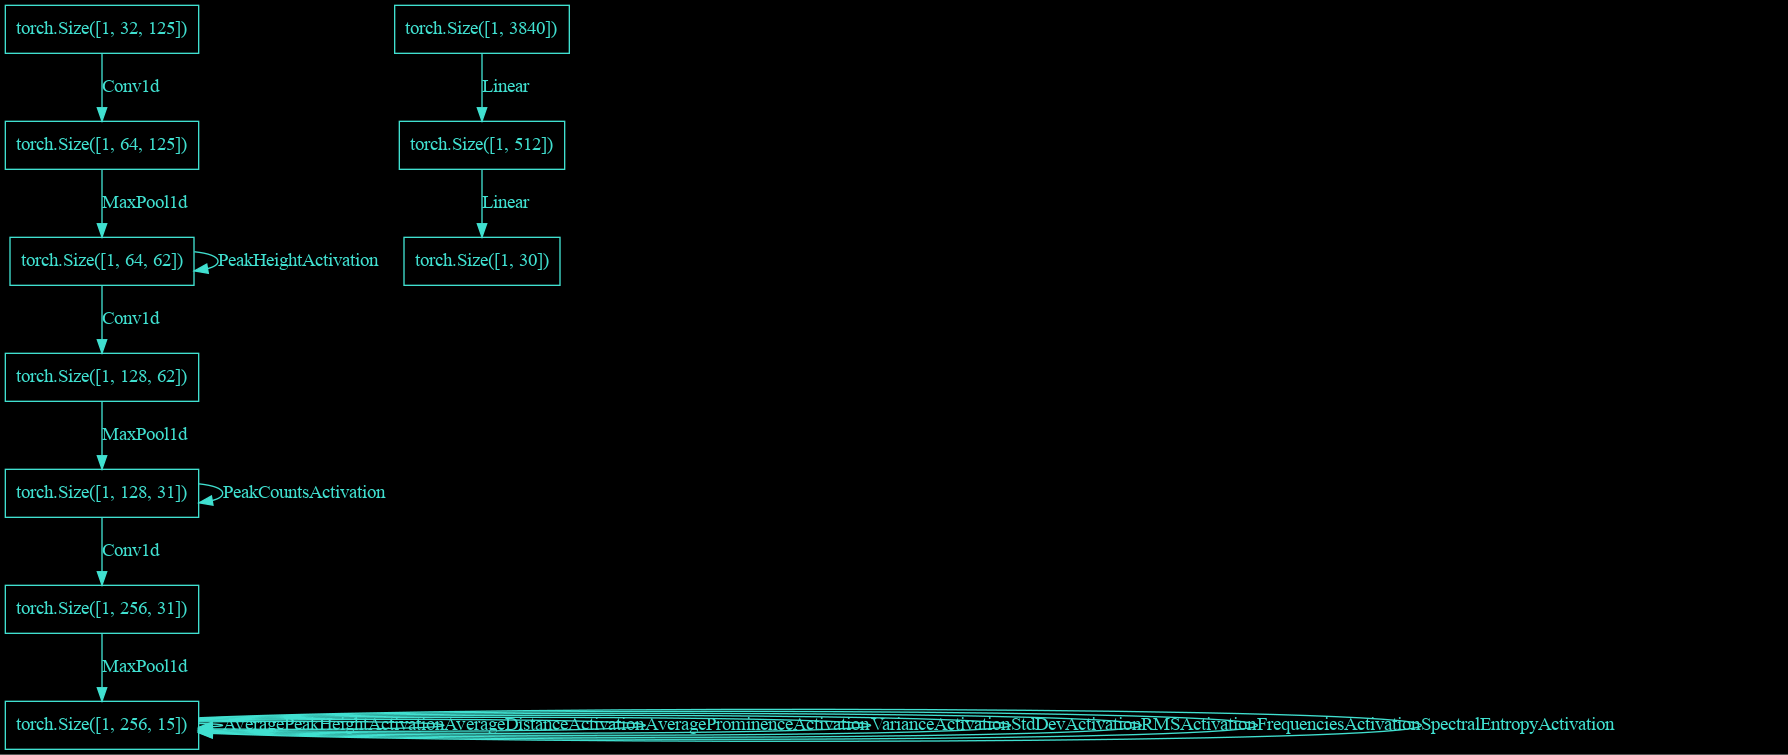

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from graphviz import Digraph
from IPython.display import display, Image
import matplotlib.pyplot as plt

# Ensure matplotlib is in inline mode
%matplotlib inline

# Function to create nodes and edges automatically
def create_graph(model, input_tensor):
    dot = Digraph(comment='Model Architecture')
    
    def add_nodes_edges(module, input, output):
        module_name = str(module.__class__).split('.')[-1].split("'")[0]
        input_name = str(input[0].shape)
        output_name = str(output.shape)
        dot.node(input_name, label=input_name, style='filled', fillcolor='black', fontcolor='turquoise', shape='box', color='turquoise')
        dot.node(output_name, label=output_name, style='filled', fillcolor='black', fontcolor='turquoise', shape='box', color='turquoise')
        dot.edge(input_name, output_name, label=module_name, color='turquoise', fontcolor='turquoise')
    
    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(add_nodes_edges)
        hooks.append(hook)
    
    model(input_tensor)
    
    for hook in hooks:
        hook.remove()
    
    return dot

# Instantiate the model with the number of features
num_features = 30  # Replace with the actual number of features to be extracted
model = CustomActivationNet(num_features=num_features)

# Create a random tensor with the appropriate shape for visualization
input_tensor = torch.randn(1, 32, 125)

# Generate the graph
dot = create_graph(model, input_tensor)

# Render the visualization with custom settings
output_path = "/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/Bio-Silicon-Synergetic-Intelligence-System/Software/CNN_feature_extraction_project/models/soul_syrup/architectures/1"
dot.format = 'png'
dot.attr(bgcolor='black')
dot.render(output_path)

# Display the image in the notebook
image_path = f"{output_path}.png"
display(Image(filename=image_path))

In [ ]:
import torch
from torch.quantization import QuantStub, DeQuantStub, get_default_qconfig, prepare_qat, convert

# Define the quantization configuration
qconfig = get_default_qconfig('fbgemm')

## weight and activation quantization WIP

In [ ]:
import torch
from torch.quantization import QuantStub, DeQuantStub, get_default_qconfig, prepare_qat, convert
import torch.nn as nn

# Define the quantization configuration
qconfig = get_default_qconfig('fbgemm')

# Modify the model for quantization
class CustomActivationNet(nn.Module):
    def __init__(self, num_features):
        super(CustomActivationNet, self).__init__()
        self.quant = QuantStub()
        self.conv1 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.activation1 = PeakHeightActivation()
        self.activation2 = PeakCountsActivation()
        self.activation3 = AveragePeakHeightActivation()
        self.activation4 = AverageDistanceActivation()
        self.activation5 = AverageProminenceActivation()
        self.activation6 = VarianceActivation()
        self.activation7 = StdDevActivation()
        self.activation8 = RMSActivation()
        self.activation9 = FrequenciesActivation()
        self.activation10 = SpectralEntropyActivation()
        self.fc1 = nn.Linear(256 * 15, 512)
        self.fc2 = nn.Linear(512, 30)
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.activation1(x)
        x = self.activation2(x)
        x = self.activation3(x)
        x = self.activation4(x)
        x = self.activation5(x)
        x = self.activation6(x)
        x = self.activation7(x)
        x = self.activation8(x)
        x = self.activation9(x)
        x = self.activation10(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dequant(x)
        return x

# Instantiate the model with the number of features
num_features = 30  # Replace with the actual number of features to be extracted
model = CustomActivationNet(num_features=num_features)

# Apply the quantization configuration to the model
model.qconfig = qconfig

# Prepare the model for quantization aware training
model = prepare_qat(model)

# Fine-tune the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  # Replace with your loss function
train_loader = ...  # Define your DataLoader
num_epochs = 10  # Define the number of epochs

model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

# Convert the model to a quantized version
quantized_model = convert(model.eval(), inplace=False)

# Save the quantized model
torch.save(quantized_model.state_dict(), 'quantized_model.pth')

## feature quantization WIP

In [ ]:
import torch
from torch.quantization import QuantStub, DeQuantStub, get_default_qconfig, prepare_qat, convert
import torch.nn as nn

# Define the quantization configuration
qconfig = get_default_qconfig('fbgemm')

class CustomActivationNet(nn.Module):
    def __init__(self, num_features):
        super(CustomActivationNet, self).__init__()
        self.quant = QuantStub()
        self.conv1 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.activation1 = PeakHeightActivation()
        self.activation2 = PeakCountsActivation()
        self.activation3 = AveragePeakHeightActivation()
        self.activation4 = AverageDistanceActivation()
        self.activation5 = AverageProminenceActivation()
        self.activation6 = VarianceActivation()
        self.activation7 = StdDevActivation()
        self.activation8 = RMSActivation()
        self.activation9 = FrequenciesActivation()
        self.activation10 = SpectralEntropyActivation()
        self.fc1 = nn.Linear(256 * 15, 512)
        self.fc2 = nn.Linear(512, 30)
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.pool1(self.conv1(x))
        x = self.quant(x)  # Quantize after each layer
        x = self.pool2(self.conv2(x))
        x = self.quant(x)
        x = self.pool3(self.conv3(x))
        x = self.quant(x)
        x = self.activation1(x)
        x = self.quant(x)
        x = self.activation2(x)
        x = self.quant(x)
        x = self.activation3(x)
        x = self.quant(x)
        x = self.activation4(x)
        x = self.quant(x)
        x = self.activation5(x)
        x = self.quant(x)
        x = self.activation6(x)
        x = self.quant(x)
        x = self.activation7(x)
        x = self.quant(x)
        x = self.activation8(x)
        x = self.quant(x)
        x = self.activation9(x)
        x = self.quant(x)
        x = self.activation10(x)
        x = x.view(x.size(0), -1)
        x = self.dequant(x)  # Dequantize before fully connected layers if needed
        x = self.fc1(x)
        x = self.quant(x)
        x = self.fc2(x)
        x = self.dequant(x)
        return x

# Instantiate the model with the number of features
num_features = 30  # Replace with the actual number of features to be extracted
model = CustomActivationNet(num_features=num_features)

# Apply the quantization configuration to the model
model.qconfig = qconfig

# Prepare the model for quantization aware training
model = prepare_qat(model)

# Fine-tune the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  # Replace with your loss function
train_loader = ...  # Define your DataLoader
num_epochs = 10  # Define the number of epochs

model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

# Convert the model to a quantized version
quantized_model = convert(model.eval(), inplace=False)

# Save the quantized model
torch.save(quantized_model.state_dict(), 'quantized_model.pth')

## performance eval WIP

## channel-wise evaluation WIP